In [1]:
# 匯入套件
import numpy as np
import pandas as pd
import itertools
import gc

In [17]:
# 定義function

# 此function為網路上的人撰寫，目的是降低DataFrame的大小
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

# 讀取資料，by chunk
def read_data_by_chunk(path, df_test, col_list, shop_tag_list, chunksize):
    reader = pd.read_csv(path,
                        error_bad_lines=False, # 會自動忽略錯誤row
                        # header=None, # 看資料有無欄位名稱
                        iterator=True,
                        usecols=col_list  #限縮要取的資料欄位
                        )
    loop = True
    chunks = []
    while loop:
        try:
            chunk = reader.get_chunk(chunksize)
            chunk = chunk[chunk.chid.isin(df_test.chid)]    #只取測試資料的前10,000 chid
            chunk = chunk[chunk.shop_tag.isin(shop_tag_list)]   #指取要預測的消費類別
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped.")
    df = pd.concat(chunks,ignore_index=True)
    return df


In [3]:
# 預先定義好的list，包含要預測的shop tag或目前要使用的columns
SHOP_TAG_LIST = ['2', '6', '10', '12',
                '13', '15', '18', '19',
                '21', '22', '25', '26',
                '36', '37', '39', '48']
COL_LIST = ['dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt', 'domestic_offline_cnt',
       'domestic_online_cnt', 'overseas_offline_cnt', 'overseas_online_cnt',
       'domestic_offline_amt_pct', 'domestic_online_amt_pct',
       'overseas_offline_amt_pct', 'overseas_online_amt_pct', 'card_1_txn_cnt',
       'card_2_txn_cnt', 'card_3_txn_cnt', 'card_4_txn_cnt', 'card_5_txn_cnt',
       'card_6_txn_cnt', 'card_7_txn_cnt', 'card_8_txn_cnt', 'card_9_txn_cnt',
       'card_10_txn_cnt', 'card_11_txn_cnt', 'card_12_txn_cnt',
       'card_13_txn_cnt', 'card_14_txn_cnt', 'card_other_txn_cnt',
       'card_1_txn_amt_pct', 'card_2_txn_amt_pct', 'card_3_txn_amt_pct',
       'card_4_txn_amt_pct', 'card_5_txn_amt_pct', 'card_6_txn_amt_pct',
       'card_7_txn_amt_pct', 'card_8_txn_amt_pct', 'card_9_txn_amt_pct',
       'card_10_txn_amt_pct', 'card_11_txn_amt_pct', 'card_12_txn_amt_pct',
       'card_13_txn_amt_pct', 'card_14_txn_amt_pct', 'card_other_txn_amt_pct']

#### 讀取測試資料，並篩選前10,000個chid

In [4]:
df_test = pd.read_csv(r'D:\Gallon\Project\07_E_SUN_2021_Winter_AI\data\需預測的顧客名單及提交檔案範例.csv')
df_test = df_test[:10000].reset_index(drop=True)
df_test

,chid,top1,top2,top3
0,10128239,18,10,6
1,10077943,48,22,6
2,10277876,22,10,39
3,10364842,37,19,13
4,10392717,2,36,26
...,...,...,...,...
9995,10203858,25,22,37
9996,10008113,22,48,15
9997,10053154,37,39,12
9998,10252782,26,18,12


#### 匯入訓練資料，並根據篩選後的測試資料(df_test)選擇部分chid

In [5]:
df = read_data_by_chunk(path=r'D:\Gallon\Project\07_E_SUN_2021_Winter_AI\data\tbrain_cc_training_48tags_hash_final.csv',
                    df_test=df_test,
                    col_list=COL_LIST,
                    shop_tag_list=SHOP_TAG_LIST,
                    chunksize=100000)

Iteration is stopped.


In [6]:
# 壓縮資料大小
df = reduce_mem_usage(df, silent=False)

Memory usage of dataframe is 144.00 MB
Memory usage after optimization is: 49.81 MB
Decreased by 65.4%


#### 建立以(df, chid, shop_tag)為index 的資料

In [8]:
indexlist = []
x = itertools.product(df.dt.unique(), df_test.chid.unique(), SHOP_TAG_LIST)
indexlist.append(np.array(list(x)))
matrix = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["dt", "chid", "shop_tag"])

In [9]:
# 改變資料型態，壓縮資料大小
matrix.dt = matrix.dt.astype('int8')
matrix.chid = matrix.chid.astype('int32')
matrix.shop_tag = matrix.shop_tag.astype('int8')
df.shop_tag = df.shop_tag.astype('int8')

In [10]:
# 將訓練資料合併進我們建立的以(df, chid, shop_tag)為index 的資料
matrix = matrix.merge(df, on=['dt', 'chid', 'shop_tag'], how='left')

In [11]:
# 資料補0，並壓縮資料
matrix.fillna(0, inplace=True)
matrix = reduce_mem_usage(matrix, silent=False)

Memory usage of dataframe is 930.18 MB
Memory usage after optimization is: 439.45 MB
Decreased by 52.8%


In [12]:
del df

In [13]:
gc.collect()

44

In [14]:
matrix.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3840000 entries, 0 to 3839999
Data columns (total 43 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   dt                        int8   
 1   chid                      int32  
 2   shop_tag                  int8   
 3   txn_cnt                   int16  
 4   txn_amt                   float32
 5   domestic_offline_cnt      int16  
 6   domestic_online_cnt       int8   
 7   overseas_offline_cnt      int8   
 8   overseas_online_cnt       int16  
 9   domestic_offline_amt_pct  float32
 10  domestic_online_amt_pct   float32
 11  overseas_offline_amt_pct  float32
 12  overseas_online_amt_pct   float32
 13  card_1_txn_cnt            int8   
 14  card_2_txn_cnt            int8   
 15  card_3_txn_cnt            int8   
 16  card_4_txn_cnt            int16  
 17  card_5_txn_cnt            int8   
 18  card_6_txn_cnt            int16  
 19  card_7_txn_cnt            int8   
 20  card_8_txn_cnt          

In [15]:
matrix.head()

,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,domestic_offline_amt_pct,...,card_6_txn_amt_pct,card_7_txn_amt_pct,card_8_txn_amt_pct,card_9_txn_amt_pct,card_10_txn_amt_pct,card_11_txn_amt_pct,card_12_txn_amt_pct,card_13_txn_amt_pct,card_14_txn_amt_pct,card_other_txn_amt_pct
0,1,10128239,2,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,10128239,6,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,10128239,10,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,10128239,12,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,10128239,13,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
oldcols = matrix.columns

## shop_tag

In [24]:
def shop_tag_mean_txn(matrix):
    shop_tag_features = matrix.query('txn_cnt > 0').groupby(['shop_tag', 'chid'])['txn_cnt'].sum().reset_index()
    shop_tag_features = shop_tag_features.groupby(['shop_tag'])['txn_cnt'].mean().reset_index(name='shop_tag_mean_txn')
    matrix = matrix.merge(shop_tag_features, on=['shop_tag'])
    return matrix
def shop_tag_frequency_txn(matrix):
    shop_tag_features = matrix.query('txn_cnt > 0').groupby(['shop_tag', 'chid'])['dt'].nunique().reset_index(name='dt_cnt')
    shop_tag_features = shop_tag_features.groupby(['shop_tag'])['dt_cnt'].mean().reset_index(name='shop_tag_frequency_txn')
    matrix = matrix.merge(shop_tag_features, on=['shop_tag'])
    return matrix

matrix = shop_tag_mean_txn(matrix)
matrix = shop_tag_frequency_txn(matrix)
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 12
    end_month = 24
    pt = matrix.query(f"dt>{start_month} & dt<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

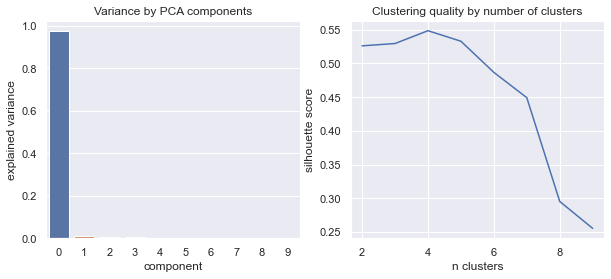

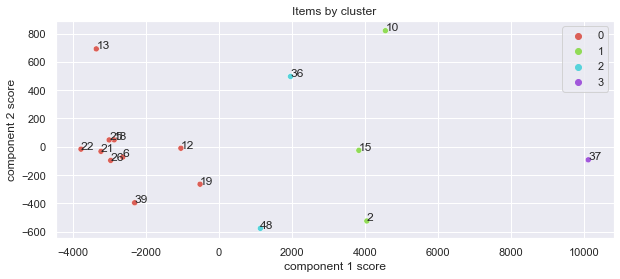

In [37]:
shop_tag_group_dict = cluster_feature(matrix,
                                    'txn_amt',
                                    'shop_tag',
                                    'dt',
                                    n_components=2,
                                    n_clusters=4,
                                    aggfunc="mean",
                                    exclude =[])
matrix['shop_tag_cluster'] = matrix['shop_tag'].map(shop_tag_group_dict)

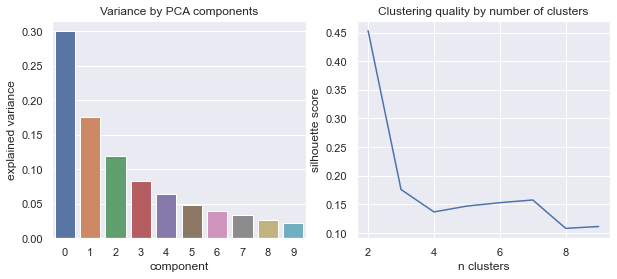

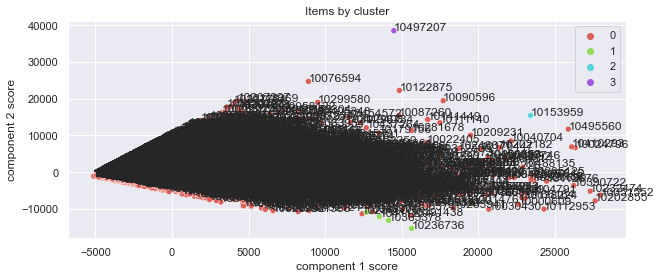

In [39]:
chid_group_dict = cluster_feature(matrix,
                                'txn_amt',
                                'chid',
                                'shop_tag',
                                n_components=10,
                                n_clusters=4,
                                aggfunc="mean",
                                exclude =[])

In [41]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [59]:
def add_pct_change(
    matrix,
    group_feats,
    target="txn_amt",
    aggfunc="mean",
    periods=1,
    lag=1,
    clip_value=None,
):
    periods = list_if_not(periods, int)
    group_feats = list_if_not(group_feats)
    group_feats_full = ["dt"] + group_feats
    dat = matrix.pivot_table(
        index=group_feats + ["dt"],
        values=target,
        aggfunc=aggfunc,
        fill_value=0,
        dropna=False,
    ).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("dt") < dat["firsts"], target] = float(
            "nan"
        )
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(
            group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat = (
            dat.groupby(group_feats)[target]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
            .rename(feat_name)
        )
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["dt"] += lag
    matrix = matrix.merge(dat, on=["dt"] + group_feats, how="left")
    matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
    return matrix

In [ ]:
matrix = add_pct_change(matrix, ["shop_tag"], "txn_amt", clip_value=3)
matrix = add_pct_change(matrix, ["shop_tag"], "txn_amt", lag=12, clip_value=3,)

In [42]:
periods = list_if_not(1, int)
group_feats = list_if_not('shop_tag')
group_feats_full = ["dt"] + group_feats
dat = matrix.pivot_table(
    index=group_feats + ["dt"],
    values='txn_amt',
    aggfunc='mean',
    fill_value=0,
    dropna=False,
).astype("float32")

In [45]:
firsts = matrix.groupby(group_feats[0]).dt.min().rename("firsts")

In [48]:
dat = dat.merge(firsts, left_on=group_feats[0], right_index=True, how="left")

In [49]:
dat.loc[dat.index.get_level_values("dt") < dat["firsts"], 'txn_amt'] = float("nan")

In [51]:
del dat["firsts"]

In [52]:
feat_name = "_".join(
    group_feats + ['txn_amt'] + ['mean'] + ["delta"] + [str(1)] + [f"lag_{1}"]
)
print(f"Adding feature {feat_name}")
dat = (
    dat.groupby(group_feats)['txn_amt']
    .transform(lambda x: x.pct_change(periods=1, fill_method="pad"))
    .rename(feat_name)
)

Adding feature shop_tag_txn_amt_mean_delta_1_lag_1


In [55]:
dat

shop_tag  dt
2         1          NaN
          2     0.022261
          3     0.052356
          4     0.034208
          5     0.016757
                  ...   
48        20    0.022628
          21    0.013867
          22    0.002480
          23    0.036123
          24   -0.143748
Name: shop_tag_txn_amt_mean_delta_1_lag_1, Length: 384, dtype: float32

In [56]:
dat = dat.clip(lower=-3, upper=3)

In [57]:
dat = dat.reset_index()
dat["dt"] += 1

In [58]:
dat

,shop_tag,dt,shop_tag_txn_amt_mean_delta_1_lag_1
0,2,2,NaN
1,2,3,0.022261
2,2,4,0.052356
3,2,5,0.034208
4,2,6,0.016757
...,...,...,...
379,48,21,0.022628
380,48,22,0.013867
381,48,23,0.002480
382,48,24,0.036123


In [29]:
pt = matrix[~matrix['shop_tag'].isin([])]

In [32]:
pt = pt.pivot_table(values='txn_amt', columns='shop_tag', index='dt', fill_value=0, aggfunc='mean')

([<matplotlib.axis.XTick at 0x20838409d88>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

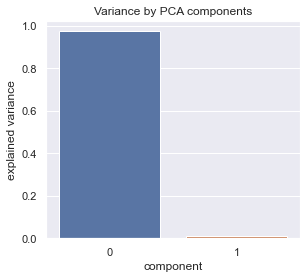

In [33]:
pt = pt.transpose()
pca = PCA(n_components=2)
components = pca.fit_transform(pt)
components = pd.DataFrame(components)
# Plot PCA explained variance
sns.set_theme()
features = list(range(pca.n_components_))
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
plt.title("Variance by PCA components")
plt.xlabel("component")
plt.ylabel("explained variance")
plt.xticks(features)

In [ ]:
matrix